<div align="center">
<font size="6"> SIIM-ISIC Melanoma Classification  </font>  
</div> 


<div align="center">
<font size="4"> Identify melanoma in lesion images  </font>  
</div> 

<img align="right" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/logo.png" data-canonical-src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/logo.png" width="280" height="280" />

Skin cancer is the most prevalent type of cancer. **Melanoma**, specifically, is responsible for **75%** of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the [Society for Imaging Informatics in Medicine (SIIM)](https://siim.org/)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the [International Skin Imaging Collaboration (ISIC)](https://www.isic-archive.com/), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

<img align="left" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/melanoma.png" data-canonical-src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/melanoma.png" width="1200" height="450" />

<h2 style=color:Teal align="left"> Table of Contents </h2>

#### 1. EfficientNet
#### 2. Load Required Libraries
#### 3. Configs
#### 4. Device
#### 5. Paths
#### 6. Augmentation
#### 7. Get dataset
#### 8. EDA
#### 9. Monitor model performance
#### 10. Build model
#### 11. kFold
#### 12. Evaluate on test
#### 13. Submit predictions
#### References


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

if False:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 1. EfficientNet </h1>

<div align="left">
<font size="4"> Model Size vs. ImageNet Accuracy.  </font>  
</div> 

EfficientNets significantly outperform other Convoluational Neural Networks [Tan, M. and Le, Q.V.. 2019]. 

<img align="left" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/flops.jpg" data-canonical-src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/flops.jpg" width="650" height="650" />  

In [2]:
# EfficientNet
!pip install -q efficientnet >> /dev/null

<div align="center">
<font size="4"> EfficientNetB0  </font>  
</div>

<img align="center" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/efficientnetb0_.png" data-canonical-src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/efficientnetb0_.png" width="1550" height="1550" />

Image: [T. A. Putra et al 2020]


In [3]:
# Select EfficientNetBx to use
# EfficientNetB0
# EfficientNetB1
# EfficientNetB2
# EfficientNetB3
# EfficientNetB4
# EfficientNetB5
# EfficientNetB6
# EfficientNetB7

MODEL = 5

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 2. Load Required Libraries </h1>

In [4]:
import re
import time
import math

import random
random.seed(a=42)

from tqdm import tqdm

import PIL

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 3. Configs </h1>

In [5]:
CFG = dict(
    net_count         =   7, 
    batch_size        =   8,  # 8; 16; 32; 64; bigger batch size => moemry allocation issue
    epochs            =   10, # 5; 10; 20;
    verbose           =   1,  # 0; 1
    
    optimizer         = 'adam',
    
    # kFold
    NSPLITS           = 5,  
    RANDOM_STATE      = 42,   
    
    # LR
    LR_START          =   0.000005, # 5e-6
    LR_MAX            =   0.000010, # 1e-5; 2e-5; 3e-5
    LR_MIN            =   0.000001, # 1e-6
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    
    # Images sizes
    read_size         = 256, # 256 (a); 384 (b); 512 (c); 768 (d);
    crop_size         = 250, # 250 (a); 370 (b); 500 (c); 750 (d);
    net_size          = 240, # 240 (a); 352 (b); 480 (c); 730 (d);
    
    # Images augs
    ROTATION          = 180.0,
    SHEAR             =   2.0,
    HZOOM             =   8.0,
    WZOOM             =   8.0,
    HSHIFT            =   8.0,
    WSHIFT            =   8.0,

    # Postprocessing
    label_smooth_fac  =   0, # 0.01; 0.05; 0.1; 0.2;
    tta_steps         =   5  # 5; 10; 15; 25; 30;
)

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 4. Device </h1>

In [6]:
DEVICE = "TPU"
#DEVICE = "GPU"

In [7]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [8]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 5. Paths </h1>

In [9]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

We have images in TFRecords of different sizes:
- 256x256
- 384x384
- 512x512
- 768x768

In [10]:
!ls ../input/melanoma*

../input/melanoma-256x256:
test00-687.tfrec  test08-687.tfrec  train.csv		train07-2174.tfrec
test01-687.tfrec  test09-687.tfrec  train00-2182.tfrec	train08-2177.tfrec
test02-687.tfrec  test10-687.tfrec  train01-2185.tfrec	train09-2178.tfrec
test03-687.tfrec  test11-687.tfrec  train02-2193.tfrec	train10-2174.tfrec
test04-687.tfrec  test12-687.tfrec  train03-2182.tfrec	train11-2176.tfrec
test05-687.tfrec  test13-687.tfrec  train04-2167.tfrec	train12-2198.tfrec
test06-687.tfrec  test14-687.tfrec  train05-2171.tfrec	train13-2186.tfrec
test07-687.tfrec  test15-677.tfrec  train06-2175.tfrec	train14-2174.tfrec

../input/melanoma-384x384:
test00-687.tfrec  test08-687.tfrec  train.csv		train07-2174.tfrec
test01-687.tfrec  test09-687.tfrec  train00-2182.tfrec	train08-2177.tfrec
test02-687.tfrec  test10-687.tfrec  train01-2185.tfrec	train09-2178.tfrec
test03-687.tfrec  test11-687.tfrec  train02-2193.tfrec	train10-2174.tfrec
test04-687.tfrec  test12-687.tfrec  train03-2182.tfrec	train11-2176.tfrec

In [11]:
# Select image size of ionterest
SIZE = 256

In [12]:
GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-%ix%i' % (SIZE,SIZE))
#GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
#GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-384x384')
#GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-512x512')
#GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-768x768')
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

In [13]:
print(len(df_train),len(df_train[df_train.target==0]),len(df_train[df_train.target==1]))

33126 32542 584


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 6. Augmentation </h1>

In [14]:
# by Chris Deotte

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])   
    
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['ROTATION'] * tf.random.normal([1], dtype='float32')
    shr = cfg['SHEAR'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['HZOOM']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['WZOOM']
    h_shift = cfg['HSHIFT'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['WSHIFT'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [15]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, cfg=None, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)                # 0.01; 0.015; 0.02
        img = tf.image.random_saturation(img, 0.75, 1.25)   # 0.5,1.5; 0.7,1.3; 0.8, 1.2; 0.9,1.1;
        img = tf.image.random_contrast(img, 0.8, 1.2)       # 0.9,1.1; 0.8,1.2;
        img = tf.image.random_brightness(img, 0.1)          # 0.10; 0.15; 0.20;

    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 7. Get dataset </h1>

In [16]:
def get_dataset(files, cfg, 
                augment = False, 
                shuffle = False, 
                repeat = False, 
                labeled=True, 
                return_image_names=True
               ):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 8. EDA </h1>

In [17]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, iy*thumb_size + iy))

    display(mosaic)

In [18]:
nrows = 6
ncols = 12
ds = get_dataset(files_train, CFG).unbatch().take(nrows*ncols)  

In [19]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), num_parallel_calls=AUTO)
ds = ds.take(ncols*nrows)
ds = ds.prefetch(AUTO)

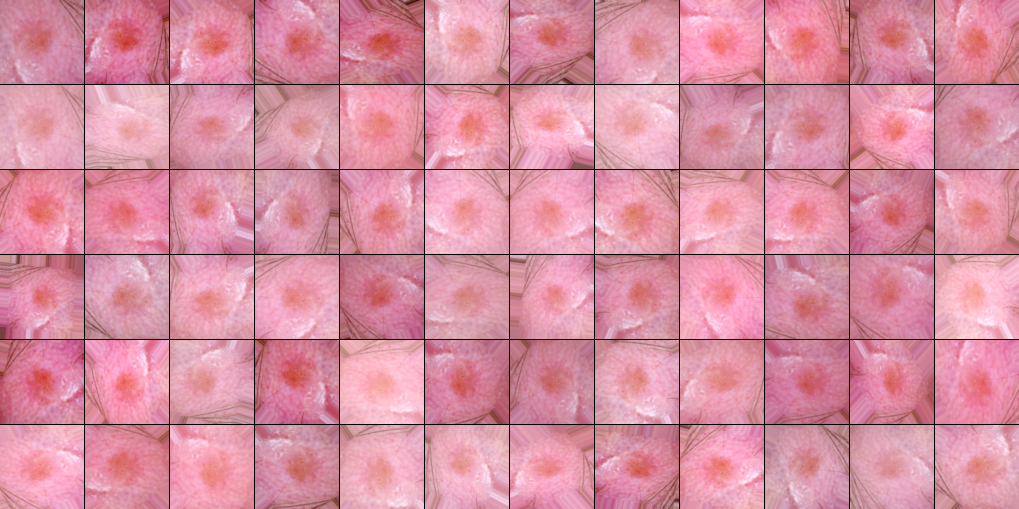

In [20]:
show_dataset(ncols*(nrows+1), ncols, nrows, ds)

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 9. Monitor model performance </h1>

In [21]:
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync # can be set dynamic cfg['LR_MAX']*cfg['batch_size'] * replicas
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    #lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                       factor=0.25, 
                                                       patience=2, 
                                                       verbose=0, 
                                                       mode='auto'
                                                      )
    return lr_callback

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 10. Build model </h1>

In [22]:
def get_model(cfg):
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)

    #constructor = getattr(efn, f'EfficientNetB1')
    constructor = getattr(efn, 'EfficientNetB{}'.format(MODEL)) # 1,3,5,6,7
    x = constructor(include_top=False, weights='imagenet', 
                    input_shape=(cfg['net_size'], cfg['net_size'], 3), 
                    pooling='avg')(dummy)
    
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs = [x]
        
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

def compile_new_model(cfg):    
    with strategy.scope():
        model = get_model(cfg)
        
        #losses = tf.keras.losses.BinaryCrossentropy() # default from_logits=False
        #losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])]
        #losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac']) for i in range(cfg['net_count'])]
        losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac']) if cfg['label_smooth_fac'] > 0 else  tf.keras.losses.BinaryCrossentropy()]
        
        model.compile(
            optimizer = cfg['optimizer'],
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model

`label_smoothing`
- Float in [0, 1]. 
    - When 0, no smoothing occurs. 
    - When > 0, we compute the loss between the predicted labels and a smoothed version of the true labels, where the smoothing squeezes the labels towards 0.5. Larger values of `label_smoothing` correspond to heavier smoothing.

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 11. kFold </h1>

In [23]:
folds = KFold(n_splits=CFG['NSPLITS'], 
              shuffle = True, 
              random_state = CFG['RANDOM_STATE'])

In [24]:
# OPTIONS

# TRAIN
optAug_tr                = True
optShuffle_tr            = True 
optRepeat_tr             = True

# TRAIN AUG
optAug_trAug             = True
optRepeat_trAug          = True
optLabeled_trAug         = False
optReturnImgNames_trAug  = False


# VALIDATION
optAug_va                = False # no Aug in validation!
optRepeat_va             = False
optLabeled_va            = False
optReturnImgNames_va     = True

# TEST AUG
optAug_tsAug             = True
optRepeat_tsAug          = True
optLabeled_tsAug         = False
optReturnImgNames_tsAug  = False


# TEST
optAug_ts                = False 
optRepeat_ts             = False
optLabeled_ts            = False
optReturnImgNames_ts     = True

In [25]:
pred_tr = pd.DataFrame()
cnt = 0

print('\nKeep patience, takes long ...')

for fold_idx, (tr_idx,va_idx) in enumerate(folds.split(files_train)):
    
    print('\nProcessing FOLD {}'.format(fold_idx))
    
    files_train_tr = files_train[tr_idx]
    files_train_va = files_train[va_idx]
    
    ds_train       = get_dataset(files_train_tr, 
                                 CFG, 
                                 augment=optAug_tr, 
                                 shuffle=optShuffle_tr, 
                                 repeat=optRepeat_tr
                                )
    
    #ds_train       = ds_train.map(lambda img, label: (img, tuple([label] * CFG['net_count'])))
    ds_train       = ds_train.map(lambda img, label: (img, tuple([label])))
    
    steps_train    = count_data_items(files_train_tr) / (CFG['batch_size'] * REPLICAS)

    
    # COMPILE MODEL
    model          = compile_new_model(CFG)
    
    # SAVE BEST MODEL EACH FOLD
    path_to_best_model = 'fold-%i.h5'%fold_idx
    saveBestModel = tf.keras.callbacks.ModelCheckpoint(filepath=path_to_best_model, 
                                                       monitor='val_loss', 
                                                       verbose=CFG['verbose'], 
                                                       save_best_only=True,
                                                       save_weights_only=True, 
                                                       mode='min', 
                                                       save_freq='epoch'
                                                      )
    print('\nTraining ...')
    history = model.fit(ds_train, 
                        epochs           = CFG['epochs'],
                        steps_per_epoch  = steps_train,
                        verbose          = 1,
                        callbacks        = [get_lr_callback(CFG), saveBestModel]
                       )
    
    #print('\nLoading best model...')
    #model.load_weights(path_to_best_model)
    
    # MAKE TRAIN  PREDICTION
    CFG['batch_size'] = 256 # increase batch size

    cnt_train   = count_data_items(files_train_va)
    steps       = cnt_train / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
    
    ds_trainAug = get_dataset(files_train_va, 
                              CFG, 
                              augment=optAug_trAug,
                              repeat=optRepeat_trAug,
                              labeled=optLabeled_trAug, 
                              return_image_names=optReturnImgNames_trAug
                             )
    # Proba
    probs = model.predict(ds_trainAug, verbose=1, steps=steps)
    probs = probs[:cnt_train * CFG['tta_steps'],:]
    probs = np.stack(np.split(probs, CFG['tta_steps'], axis=0), axis=0)
    
    ds = get_dataset(files_train_va, 
                     CFG, 
                     augment=optAug_va, 
                     repeat=optRepeat_va, 
                     labeled=optLabeled_va, 
                     return_image_names=optReturnImgNames_va
                    )
    
    image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])
    
    pred = pd.DataFrame(dict(image_name = image_names,
                             target     = np.mean(probs[:,:,0], axis=0))
                       )
    
    pred_tr = pd.concat([pred_tr, pred], axis=0)
    
    # MAKE SUBMISSION DATA
    cnt_test   = count_data_items(files_test)
    steps      = cnt_test / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
    
    ds_testAug = get_dataset(files_test, 
                             CFG, 
                             augment=optAug_tsAug, 
                             repeat=optRepeat_tsAug, 
                             labeled=optLabeled_tsAug, 
                             return_image_names=optReturnImgNames_tsAug
                            )

    probs = model.predict(ds_testAug, verbose=1, steps=steps)
    probs = probs[:cnt_test * CFG['tta_steps'],:]
    probs = np.stack(np.split(probs, CFG['tta_steps'], axis=0), axis=0)
    
    if cnt == 0:
        probs_sub = probs/CFG['NSPLITS']
        cnt = 1
    else:
        probs_sub += probs/CFG['NSPLITS']


Keep patience, takes long ...

Processing FOLD 0
115515392/115515256 [==============================] - 3s 0us/step
Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 240, 240, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, 2048)              28513520  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________

Training ...
Epoch 1/10
408/408 [==============================] - 159s 118ms/step - loss: 0.1064 - auc: 0.6902
Epoch 2/

In [26]:
pred_tr = pred_tr.sort_values('image_name') 
pred_tr.to_csv('pred_tr.csv', index=False)
pred_tr.head(10)

,image_name,target
3,ISIC_0015719,0.000744
1,ISIC_0052212,0.000029
6,ISIC_0068279,0.010846
2,ISIC_0074268,0.001601
0,ISIC_0074311,0.000029
2,ISIC_0074542,0.000006
5,ISIC_0075663,0.017814
9,ISIC_0075914,0.002268
1,ISIC_0076262,0.003259
5,ISIC_0076545,0.024150


In [27]:
# RESULTS
pred_tr = pred_tr.merge(df_train, on = ["image_name"], how = "left")
print(roc_auc_score(pred_tr["target_y"], pred_tr["target_x"]))

0.6884652103120571


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 12. Evaluate on test </h1>

In [28]:
ds = get_dataset(files_test, 
                 CFG, 
                 augment=optAug_ts, 
                 repeat=optRepeat_ts, 
                 labeled=optLabeled_ts, 
                 return_image_names=optReturnImgNames_ts
                )

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> 13. Submit predictions </h1>

In [29]:
submission = pd.DataFrame(dict(image_name = image_names,
                               target     = np.mean(probs_sub[:,:,0], axis=0))
                               #target     = np.mean(probs, axis = 1))
                         )
                                        

submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head(10)

,image_name,target
9905,ISIC_0052060,0.000449
1443,ISIC_0052349,0.001015
3120,ISIC_0058510,0.000476
4870,ISIC_0073313,0.000459
5494,ISIC_0073502,0.002609
4537,ISIC_0074618,0.002350
4819,ISIC_0076801,0.000723
7203,ISIC_0077586,0.001659
10897,ISIC_0082004,0.001831
5093,ISIC_0082785,0.004144


<h1 style="background-color:LightSeaGreen; font-family:newtimeroman; font-size:200%; text-align:left;"> References </h1>

- [Notebook] [Incredible TPUs - finetune EffNetB0-B6 at once](https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once)  
- [Notebook] [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)  
- [Notebook] [Rotation Augmentation GPU/TPU](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)  
- [Notebook] [SIIM-ISIC EfficientNet B6 Single Model](https://www.kaggle.com/roydatascience/siim-isic-efficientnet-b6-single-model-lb-0-9475)  
- [MSThesis] [Medical images analyses using neural networks](https://ela.kpi.ua/bitstream/123456789/38254/1/Doms_magistr.pdf)  
- [TF/Keras] [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)  
- [TF/Keras] [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint), [see also](https://keras.io/api/callbacks/model_checkpoint/)  
- [TF/Keras] [BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)  
- [EfficientNet] [EfficientNet](https://github.com/qubvel/efficientnet)  
- [Article] Tan, M. and Le, Q.V. (2019). Efficientnet: rethinking model scaling for convolutional neural networks. arXiv preprint [arXiv:1905.11946](https://arxiv.org/pdf/1905.11946.pdf)
- [Article] T. A. Putra, S. I. Rufaida and J. Leu, "Enhanced Skin Condition Prediction Through Machine Learning Using Dynamic Training and Testing Augmentation," in IEEE Access, vol. 8, pp. 40536-40546, 2020, [doi: 10.1109/ACCESS.2020.2976045](https://ieeexplore.ieee.org/document/9007729)